In [93]:
from dataclasses import dataclass
from typing import Iterable, Optional, Dict, Sequence, Literal, Any
import pandas as pd
from pathlib import Path
from typing import Literal
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DIRECTIONS: Sequence[str] = ("NB", "SB", "EB", "WB")
MOVEMENTS: Sequence[str] = ("Left", "Thru", "Right", "U-Turns")
DATASETS = ("combined", "passenger", "heavy")

# Peak period search windows
PERIODS = {
    "AM": ("06:00", "10:00"),
    "MD": ("10:00", "15:00"),
    "PM": ("15:00", "19:00"),
}

In [94]:

def parse_direction_headers(header_row: Sequence[str]) -> Dict[str, str]:
    mapping: Dict[str, str] = {}
    for value in header_row:
        if not isinstance(value, str):
            continue
        parts = [part.strip() for part in value.replace("\r", "").split("\n") if part.strip()]
        if len(parts) < 2:
            continue
        direction = parts[-1].lower()
        road = " ".join(parts[:-1])
        if direction == "northbound":
            mapping["NB"] = road
        elif direction == "southbound":
            mapping["SB"] = road
        elif direction == "eastbound":
            mapping["EB"] = road
        elif direction == "westbound":
            mapping["WB"] = road
    return mapping

def _rename_turn_columns(df: pd.DataFrame) -> pd.DataFrame:
    rename: Dict[str, str] = {}
    data_cols = df.columns[1:]
    for approach, chunk in zip(DIRECTIONS, (data_cols[i:i + 4] for i in range(0, len(data_cols), 4))):
        for movement, old in zip(MOVEMENTS, chunk):
            code = movement.split("-")[0][0]
            rename[old] = f"{approach}_{code}"
    return df.rename(columns=rename)

def apply_factors(df: pd.DataFrame, factor) -> pd.DataFrame:
    return df.apply(lambda x: x * factor)

def _phf(series: pd.Series, window_td: pd.Timedelta, interval: pd.Timedelta) -> float:
    bins = series.dropna()
    if bins.empty:
        return float("nan")
    max_bin = float(bins.max())
    if max_bin <= 0:
        return float("nan")
    bins_per_window = int(round(window_td / interval))
    return float(bins.sum()) / (bins_per_window * max_bin)

@dataclass
class IntersectionData:
    name: str
    count_date: pd.Timestamp
    northbound_road: str
    southbound_road: str
    eastbound_road: str
    westbound_road: str
    passenger: pd.DataFrame
    heavy: Optional[pd.DataFrame] = None

    @classmethod
    def from_workbook(cls, source: str, *, name: str,
                      northbound_road: Optional[str] = None,
                      southbound_road: Optional[str] = None,
                      eastbound_road: Optional[str] = None,
                      westbound_road: Optional[str] = None) -> "IntersectionData":
        source_path = Path(source)

        passenger = pd.read_excel(source_path, sheet_name="Passenger Vehicles", header=9)
        heavy = pd.read_excel(source_path, sheet_name="Heavy Trucks", header=9)

        passenger = _rename_turn_columns(passenger)
        heavy = _rename_turn_columns(heavy)

        header_sheet = pd.read_excel(source_path, sheet_name="Passenger Vehicles", header=None, nrows=1)
        road_names = parse_direction_headers(header_sheet.iloc[0])

        date_sheet = pd.read_excel(source_path, header=None)
        count_date = pd.to_datetime(date_sheet.iat[1, 2]).date()

        return cls(
            name=name,
            count_date=count_date,
            northbound_road=northbound_road or road_names.get("NB", ""),
            southbound_road=southbound_road or road_names.get("SB", ""),
            eastbound_road=eastbound_road or road_names.get("EB", ""),
            westbound_road=westbound_road or road_names.get("WB", ""),
            passenger=passenger,
            heavy=heavy,
        )
    
    def combined(self) -> pd.DataFrame:
        base = (
            self.passenger.set_index("Start Time")
            if "Start Time" in self.passenger.columns
            else self.passenger.copy()
        )
        if self.heavy is not None:
            hv = (
                self.heavy.set_index("Start Time")
                if "Start Time" in self.heavy.columns
                else self.heavy.copy()
            )
            hv = hv.reindex(base.index, fill_value=0)
            combined = base.add(hv, fill_value=0)
        else:
            combined = base
        return combined.reset_index()
    
    def _resolve_frame(self, dataset: Literal["combined", "passenger", "heavy"] | pd.DataFrame) -> pd.DataFrame:
        """Internal helper to choose which dataframe to analyze."""
        if isinstance(dataset, pd.DataFrame):
            return dataset.copy()
        if dataset == "combined":
            return self.combined()
        if dataset == "passenger":
            return self.passenger.copy()
        if dataset == "heavy":
            if self.heavy is None:
                raise ValueError("No heavy-vehicle dataframe is available.")
            return self.heavy.copy()
        raise ValueError(f"Unknown dataset selection: {dataset!r}")
    
    def find_peaks_total_volume(
        self,
        dataset: Literal["combined", "passenger", "heavy"] | pd.DataFrame = "combined",
        periods: dict[str, tuple[str, str]] = PERIODS,
        window: str = "60min",
    ) -> pd.DataFrame:
        """Determines peak hours based on total instersection entering volume"""
        frame = self._resolve_frame(dataset)
        if "Start Time" not in frame.columns:
            raise ValueError("Expected a 'Start Time' column.")

        # Build full timestamps from the recorded date + time-of-day values.
        date_str = (
            self.count_date.date().isoformat()
            if isinstance(self.count_date, pd.Timestamp)
            else str(self.count_date)
        )
        ts = pd.to_datetime(date_str + " " + frame["Start Time"].astype(str))

        base = frame.drop(columns=["Start Time"]).set_index(ts)
        base["total"] = base.sum(axis=1)

        # Determine the bin size (e.g., 15 minutes) for back-calculating the start.
        if len(base.index) >= 2:
            interval = (base.index.to_series().diff().dropna().iloc[0])
        else:
            interval = pd.to_timedelta("15min")
        window_td = pd.to_timedelta(window)

        results = []
        for label, (start_clock, end_clock) in periods.items():
            period_slice = base.between_time(start_clock, end_clock, inclusive="left")
            if period_slice.empty:
                results.append(
                    {"period": label, "peak_start": pd.NaT, "peak_end": pd.NaT, "peak_total": float("nan")}
                )
                continue

            rolling_totals = period_slice["total"].rolling(window_td).sum()
            peak_end = rolling_totals.idxmax()
            peak_start = peak_end - window_td + interval

            results.append(
                {
                    "Period": label,
                    "Peak Start": peak_start,
                    "Peak End": peak_end,
                    "Peak Total": rolling_totals.loc[peak_end],
                }
            )
        return pd.DataFrame(results)

    def peak_15min_by_movement(
        self,
        dataset: Literal["combined", "passenger", "heavy"] | pd.DataFrame = "combined",
        periods: dict[str, tuple[str, str]] = PERIODS,
        window: str = "60min",
    ) -> pd.DataFrame:
        """
        For each named peak period (AM/MD/PM), report the maximum 15-minute volume
        observed for every movement column inside the peak-hour window.

        `dataset` may be "combined" (default), "passenger", "heavy", or any dataframe
        that looks like the others (must include a 'Start Time' column).
        """
        frame = self._resolve_frame(dataset)
        peaks = self.find_peaks_total_volume(dataset=frame, periods=periods, window=window)

        if "Start Time" not in frame.columns:
            raise ValueError("Expected a 'Start Time' column in the selected dataset.")

        date_str = (
            self.count_date.date().isoformat()
            if isinstance(self.count_date, pd.Timestamp)
            else str(self.count_date)
        )
        ts = pd.to_datetime(date_str + " " + frame["Start Time"].astype(str))
        base = frame.drop(columns=["Start Time"]).set_index(ts)

        peaks_iter = peaks.set_index("Period") if "Period" in peaks.columns else peaks.copy()

        summary_rows = []
        for label, peak in peaks_iter.iterrows():
            peak_start = peak.get("Peak Start")
            peak_end = peak.get("Peak End")

            if pd.isna(peak_start) or pd.isna(peak_end):
                summary_rows.append(pd.Series(dtype=float, name=label))
                continue

            window_slice = base.loc[peak_start:peak_end]
            summary_rows.append(window_slice.max().rename(label))

        return pd.DataFrame(summary_rows)
    
    def apply_adjustments(
        self,
        *,
        factor: float | None = None,
        movements: Sequence[str] | None = None,
        copy: bool = False,
    ) -> tuple[pd.DataFrame, Optional[pd.DataFrame]]:
        """
        Scale passenger and heavy datasets by a common factor and round results up.

        factor : float | None
            Multiplier applied to the selected movement columns. When None, data
            is returned unchanged (but copied if `copy=True`).
        movements : Sequence[str] | None
            Movement column names to adjust; defaults to every movement column.
        copy : bool
            When True return adjusted copies and leave originals intact.
        """
        def _apply(df: Optional[pd.DataFrame]) -> Optional[pd.DataFrame]:
            if df is None:
                return None
            target = df.copy() if copy else df
            if factor is None:
                return target
            cols = [c for c in target.columns if c != "Start Time"]
            if movements is not None:
                allowed = set(movements)
                cols = [c for c in cols if c in allowed]
            if cols:
                scaled = target.loc[:, cols].astype(float) * factor
                target.loc[:, cols] = scaled
            return target

        passenger_df = _apply(self.passenger)
        heavy_df = _apply(self.heavy)

        if copy:
            return passenger_df, heavy_df
        if passenger_df is not None:
            self.passenger = passenger_df
        if heavy_df is not None and self.heavy is not None:
            self.heavy = heavy_df
        # return self.passenger, self.heavy

    def peak_hour_totals_by_movement(
        self,
        dataset: Literal["combined", "passenger", "heavy"] | pd.DataFrame = "combined",
        periods: dict[str, tuple[str, str]] = PERIODS,
        window: str = "60min",
        include_total: bool = True,
        peak_windows: Optional[pd.DataFrame] = None,
    ) -> pd.DataFrame:
        """
        Sum every movement over the peak-hour window for each named period.
        If `peak_windows` is provided it must contain Peak Start/Peak End for each
        period and those windows will be used instead of recomputing them.
        """
        frame = self._resolve_frame(dataset)

        if peak_windows is None:
            peak_windows = self.find_peaks_total_volume(dataset=frame, periods=periods, window=window)
        peak_windows = (
            peak_windows.set_index("Period") if "Period" in peak_windows.columns else peak_windows.copy()
        )

        if "Start Time" not in frame.columns:
            raise ValueError("Expected a 'Start Time' column in the selected dataset.")

        date_str = (
            self.count_date.date().isoformat()
            if isinstance(self.count_date, pd.Timestamp)
            else str(self.count_date)
        )
        ts = pd.to_datetime(date_str + " " + frame["Start Time"].astype(str))
        base = frame.drop(columns=["Start Time"]).set_index(ts)

        rows = []
        for label, peak in peak_windows.iterrows():
            peak_start = peak.get("Peak Start")
            peak_end = peak.get("Peak End")

            if pd.isna(peak_start) or pd.isna(peak_end):
                rows.append(pd.Series(dtype=float, name=label))
                continue

            window_slice = base.loc[peak_start:peak_end]
            totals = window_slice.sum().rename(label)
            if include_total:
                totals["Total"] = peak.get("Peak Total", window_slice.values.sum())
            rows.append(totals)

        return pd.DataFrame(rows)

    
    def estimate_approach_aadt(
            self,
            dataset: Literal["combined", "passenger", "heavy"] | pd.DataFrame = "combined",
            expansion_factor: float = 1.0,
            seasonal_factor: float = 1.0,
            growth_factor: float = 1.0
        ) -> pd.DataFrame:
            """
            Estimate AADT for each approach by multiplying the total observed volume
            by an expansion factor and rounding the result up to the next integer.

            Parameters
            ----------
            dataset : {"combined", "passenger", "heavy"} or DataFrame
                Which data to analyze (default: combined totals). You can supply a
                custom DataFrame with the same structure if needed.
            expansion_factor : float 
                Multiplier(s) to convert observed totals to AADT

            Returns
            -------
            pd.DataFrame with columns:
                - Approach
                - Observed Volume
                - Expansion Factor
                - Estimated AADT (rounded up)
            """
            frame = self._resolve_frame(dataset)
            values = frame.copy()
            if "Start Time" in values.columns:
                values = values.drop(columns=["Start Time"])

            approach_totals: dict[str, float] = {}
            for approach in DIRECTIONS:
                cols = [c for c in values.columns if c.startswith(f"{approach}_")]
                if cols:
                    approach_totals[approach] = float(values[cols].sum().sum())

            rows = []
            for approach, observed in approach_totals.items():
                expanded = observed * expansion_factor
                seasonal = expanded * seasonal_factor
                grown = seasonal * growth_factor
                rows.append(
                    {
                        "Approach": approach,
                        "Observed Volume": observed,
                        "Expansion Factor": expansion_factor,
                        "Seasonal Factor": seasonal_factor,
                        "growth_factor": growth_factor,
                        "Estimated AADT": np.ceil(grown)
                    }
                )

            return pd.DataFrame(rows).set_index("Approach")

    def peak_hour_factor_for_peak_period(
        self,
        dataset: Literal["combined", "passenger", "heavy"] | pd.DataFrame = "combined",
        periods: dict[str, tuple[str, str]] = PERIODS,
        window: str = "60min",
        include_approach: bool = False,
        include_movement: bool = False,
    ) -> pd.DataFrame | dict[str, pd.DataFrame]:
        """
        Compute PHFs for the peak-hour window identified in each named period.

        By default returns a DataFrame with one intersection-wide PHF per period.
        Set `include_approach` and/or `include_movement` to also receive PHFs by
        approach or by individual movement. When either option is enabled, the
        result is a dict keyed by the requested levels.
        """
        frame = self._resolve_frame(dataset)
        peaks = self.find_peaks_total_volume(dataset=frame, periods=periods, window=window)

        if "Start Time" not in frame.columns:
            raise ValueError("Expected a 'Start Time' column in the selected dataset.")

        date_str = (
            self.count_date.date().isoformat()
            if isinstance(self.count_date, pd.Timestamp)
            else str(self.count_date)
        )
        ts = pd.to_datetime(date_str + " " + frame["Start Time"].astype(str))
        base = frame.drop(columns=["Start Time"]).set_index(ts)

        if len(base.index) >= 2:
            interval = base.index.to_series().diff().dropna().iloc[0]
        else:
            interval = pd.to_timedelta("15min")
        window_td = pd.to_timedelta(window)

        peaks_iter = peaks.set_index("Period") if "Period" in peaks.columns else peaks.copy()

        def calc_phf(series: pd.Series) -> float:
            bins = series.dropna()
            if bins.empty:
                return float("nan")
            max_bin = float(bins.max())
            if max_bin <= 0:
                return float("nan")
            bins_per_window = int(round(window_td / interval))
            return float(bins.sum()) / (bins_per_window * max_bin)

        intersection_rows = []
        approach_rows = []
        movement_rows = []

        for label, peak in peaks_iter.iterrows():
            peak_start = peak.get("Peak Start")
            peak_end = peak.get("Peak End")
            if pd.isna(peak_start) or pd.isna(peak_end):
                intersection_rows.append({"Period": label, "PHF": float("nan")})
                if include_approach:
                    approach_rows.append({"Period": label})
                if include_movement:
                    movement_rows.append({"Period": label})
                continue

            window_slice = base.loc[peak_start:peak_end]

            intersection_rows.append(
                {"Period": label, "PHF": calc_phf(window_slice.sum(axis=1))}
            )

            if include_approach:
                row = {"Period": label}
                for approach in DIRECTIONS:
                    cols = [c for c in window_slice.columns if c.startswith(f"{approach}_")]
                    if cols:
                        row[approach] = calc_phf(window_slice[cols].sum(axis=1))
                approach_rows.append(row)

            if include_movement:
                row = {"Period": label}
                for col in window_slice.columns:
                    row[col] = calc_phf(window_slice[col])
                movement_rows.append(row)

        intersection_df = pd.DataFrame(intersection_rows).set_index("Period")

        if not include_approach and not include_movement:
            return intersection_df

        result: dict[str, pd.DataFrame] = {"intersection": intersection_df}
        if include_approach:
            result["approach"] = pd.DataFrame(approach_rows).set_index("Period")
        if include_movement:
            result["movement"] = pd.DataFrame(movement_rows).set_index("Period")
        return result
    

    def generate_turning_movement_report(
        self,
        *,
        dataset: Literal["combined", "passenger", "heavy"] | pd.DataFrame = "combined",
        periods: dict[str, tuple[str, str]] = PERIODS,
        window: str = "60min",
        seasonal_factor: float = 1.0,
        growth_factor: float = 1.0,
        expansion_factor: float | dict[str, float] = 1.0,
    ) -> dict[str, Any]:
        """
        Build peak-period summary tables (AM/MD/PM) plus an approach AADT table.

        Seasonal and growth multipliers are applied only to create the adjusted
        volume rows; the redundant factor rows are intentionally omitted.
        """
        frame = self._resolve_frame(dataset)
        if "Start Time" not in frame.columns:
            raise ValueError("Expected a 'Start Time' column in the selected dataset.")

        period_windows = self.find_peaks_total_volume(dataset=frame, periods=periods, window=window)
        period_windows = period_windows.set_index("Period") if "Period" in period_windows.columns else period_windows.copy()

        peak15 = self.peak_15min_by_movement(dataset=frame, periods=periods, window=window)
        totals = self.peak_hour_totals_by_movement(
            dataset=frame,
            periods=periods,
            window=window,
            include_total=False,
            peak_windows=period_windows,
        )

        if self.heavy is not None:
            heavy_totals = self.peak_hour_totals_by_movement(
                dataset="heavy",
                periods=periods,
                window=window,
                include_total=False,
                peak_windows=period_windows,
            )
        else:
            heavy_totals = pd.DataFrame(0.0, index=totals.index, columns=totals.columns)

        phf_data = self.peak_hour_factor_for_peak_period(dataset=frame, periods=periods, window=window, include_movement=True)
        movement_phf = phf_data["movement"] if isinstance(phf_data, dict) else pd.DataFrame()

        base_cols = set(totals.columns) | set(peak15.columns) | set(heavy_totals.columns) | set(movement_phf.columns)
        ordered_cols: list[str] = []
        for approach in DIRECTIONS:
            for mv_code in ("L", "T", "R", "U"):
                key = f"{approach}_{mv_code}"
                if key in base_cols:
                    ordered_cols.append(key)

        approach_names = {
            "NB": ("Northbound", getattr(self, "northbound_road", "") or ""),
            "SB": ("Southbound", getattr(self, "southbound_road", "") or ""),
            "EB": ("Eastbound", getattr(self, "eastbound_road", "") or ""),
            "WB": ("Westbound", getattr(self, "westbound_road", "") or ""),
        }
        movement_labels = {"L": "Left", "T": "Through", "R": "Right", "U": "U-Turn"}

        def format_columns(columns: list[str]) -> pd.MultiIndex:
            tuples = []
            for col in columns:
                approach, mv = col.split("_", 1)
                direction_label, road = approach_names.get(approach, (approach, ""))
                top = f"{direction_label}\n{road}" if road else direction_label
                tuples.append((top, movement_labels.get(mv, mv)))
            return pd.MultiIndex.from_tuples(tuples, names=["Approach", "Movement"])

        tables: dict[str, pd.DataFrame] = {}
        season_mult = float(seasonal_factor or 1.0)
        growth_mult = float(growth_factor or 1.0)

        for label in period_windows.index:
            total_series = totals.loc[label].reindex(ordered_cols).astype(float) if label in totals.index else pd.Series(0.0, index=ordered_cols)
            peak15_series = peak15.loc[label].reindex(ordered_cols).astype(float) if label in peak15.index else pd.Series(0.0, index=ordered_cols)
            heavy_series = heavy_totals.loc[label].reindex(ordered_cols).astype(float) if label in heavy_totals.index else pd.Series(0.0, index=ordered_cols)
            phf_series = movement_phf.loc[label].reindex(ordered_cols) if label in movement_phf.index else pd.Series(np.nan, index=ordered_cols)

            percent_series = heavy_series.divide(total_series.replace(0, np.nan)) * 100.0

            rows = [
                pd.Series(peak15_series, name="Peak 15-Min Volume"),
                pd.Series(total_series, name="Counted Total Volume"),
                pd.Series(heavy_series, name="Counted Heavy Vehicles"),
                pd.Series(percent_series, name="Percent Heavy Vehicles"),
                pd.Series(phf_series, name="Peak Hour Factor"),
            ]

            if season_mult != 1.0:
                seasonal = np.ceil(total_series * season_mult)
                rows.append(pd.Series(seasonal, name="Seasonal Adjusted Volume"))

            if growth_mult != 1.0:
                projected = np.ceil(total_series * season_mult * growth_mult)
                rows.append(pd.Series(projected, name="Projected Volume"))

            table = pd.DataFrame(rows)
            table.columns = format_columns(ordered_cols)
            tables[label] = table

        # Approach-level AADT summary
        observed_frame = frame.drop(columns=["Start Time"]).astype(float)
        approach_totals: dict[str, float] = {}
        label_to_code: dict[str, str] = {}
        for code, (direction_label, road) in approach_names.items():
            cols = [c for c in observed_frame.columns if c.startswith(f"{code}_")]
            if not cols:
                continue
            label = f"{direction_label}\n{road}" if road else direction_label
            label_to_code[label] = code
            approach_totals[label] = float(observed_frame[cols].sum().sum())

        def factor_for(code: str) -> float:
            if isinstance(expansion_factor, dict):
                return float(
                    expansion_factor.get(code, expansion_factor.get(approach_names.get(code, ("", ""))[0], expansion_factor.get("default", 1.0)))
                )
            return float(expansion_factor)

        observed_row = pd.Series(approach_totals, name="Observed Approach Volume")

        expanded_row = {}
        seasonal_row = {}
        design_row = {}
        for label, observed_value in approach_totals.items():
            code = label_to_code[label]
            expansion = factor_for(code)
            expanded_row[label] = np.ceil(observed_value * expansion)
            if season_mult != 1.0:
                seasonal_row[label] = np.ceil(observed_value * expansion * season_mult)
            if growth_mult != 1.0:
                design_row[label] = np.ceil(observed_value * expansion * season_mult * growth_mult)

        approach_rows = [observed_row, pd.Series(expanded_row, name="Expanded Volume")]
        if seasonal_row:
            approach_rows.append(pd.Series(seasonal_row, name="Seasonally Adjusted AADT"))
        if design_row:
            approach_rows.append(pd.Series(design_row, name="Design Year AADT"))

        approach_summary = pd.DataFrame(approach_rows)

        metadata = {
            "intersection": self.name,
            "count_date": self.count_date,
            "northbound_road": self.northbound_road,
            "southbound_road": self.southbound_road,
            "eastbound_road": self.eastbound_road,
            "westbound_road": self.westbound_road,
            "seasonal_factor": season_mult,
            "growth_factor": growth_mult,
            "expansion_factor": expansion_factor,
        }

        return {
            "metadata": metadata,
            "period_windows": period_windows[["Peak Start", "Peak End", "Peak Total"]],
            "period_tables": tables,
            "approach_summary": approach_summary,
        }


@dataclass
class IntersectionConfig:
    name: str
    source: str
    seasonal_factor: float = 1.0
    growth_factor: float = 1.0
    expansion_factor: float | dict[str, float] = 1.0
    northbound_road: str | None = None
    southbound_road: str | None = None
    eastbound_road: str | None = None
    westbound_road: str | None = None

class BatchRunner:
    def __init__(self, configs: Iterable[IntersectionConfig]):
        self.configs = list(configs)
        self.intersections: Dict[str, IntersectionData] = {}
        self.reports: Dict[str, dict[str, Any]] = {}

    def load_all(self) -> Dict[str, IntersectionData]:
        for cfg in self.configs:
            ix = IntersectionData.from_workbook(
                cfg.source,
                name=cfg.name,
                northbound_road=cfg.northbound_road,
                southbound_road=cfg.southbound_road,
                eastbound_road=cfg.eastbound_road,
                westbound_road=cfg.westbound_road,
            )
            self.intersections[cfg.name] = ix
        return self.intersections

    def build_reports(self, **kwargs) -> Dict[str, dict[str, Any]]:
        if not self.intersections:
            self.load_all()
        for cfg in self.configs:
            ix = self.intersections[cfg.name]
            self.reports[cfg.name] = ix.generate_turning_movement_report(
                seasonal_factor=cfg.seasonal_factor,
                growth_factor=cfg.growth_factor,
                expansion_factor=cfg.expansion_factor,
                **kwargs,
            )
        return self.reports

def export_report_to_excel(
    report: dict,
    out_path: str | Path,
    *,
    include_metadata: bool = True,
    freeze_panes: tuple[int, int] = (2, 2),
) -> None:
    """
    Persist a single report (from generate_turning_movement_report) to an Excel workbook.

    Sheets:
      - Metadata (optional): key/value pairs from report["metadata"]
      - One sheet per peak period, e.g. "AM", "MD", "PM"
      - Approach_AADT: report["approach_summary"]
      - Peak_Windows: report["period_windows"]
    """
    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)

    with pd.ExcelWriter(out_path, engine="xlsxwriter") as writer:
        workbook = writer.book
        header_fmt = workbook.add_format({"bold": True, "bg_color": "#DDEBF7"})
        percent_fmt = workbook.add_format({"num_format": "0.0%", "align": "right"})
        number_fmt = workbook.add_format({"num_format": "#,##0", "align": "right"})

        if include_metadata:
            metadata = pd.Series(report["metadata"]).rename("Value")
            metadata.to_frame().to_excel(writer, sheet_name="Metadata")
            sheet = writer.sheets["Metadata"]
            sheet.set_column("A:A", 28, header_fmt)
            sheet.set_column("B:B", 40)

        # Peak period tables
        for period, table in report["period_tables"].items():
            sheet_name = period.replace(" ", "_")
            table.to_excel(writer, sheet_name=sheet_name)
            sheet = writer.sheets[sheet_name]
            sheet.freeze_panes(*freeze_panes)
            sheet.set_row(0, None, header_fmt)  # top header row
            sheet.set_column(0, 0, 28)          # row labels
            sheet.set_column(1, table.shape[1], 14, number_fmt)

            # format Percent Heavy rows
            if "Percent Heavy Vehicles" in table.index:
                row_idx = table.index.get_loc("Percent Heavy Vehicles") + 1
                sheet.set_row(row_idx, None, percent_fmt)

        # Peak windows sheet
        report["period_windows"].to_excel(writer, sheet_name="Peak_Windows")
        writer.sheets["Peak_Windows"].set_column("A:C", 22)

        # Approach AADT sheet
        report["approach_summary"].to_excel(writer, sheet_name="Approach_AADT")
        sheet = writer.sheets["Approach_AADT"]
        sheet.set_column("A:A", 28, header_fmt)
        sheet.set_column("B:Z", 16, number_fmt)

    print(f"Wrote {out_path}")

def plot_peak_stacked_bars(report, period="AM", movements=None, colors=None, ax=None):
    table = report["period_tables"][period]
    series = table.loc["Counted Total Volume"]
    if not isinstance(series.index, pd.MultiIndex) or series.index.nlevels != 2:
        raise ValueError("Expected peak tables with (approach, movement) multi-index columns.")
    df = series.unstack(level=1).fillna(0)  # rows = approaches, columns = movements
    if movements:
        df = df[[m for m in df.columns if m in movements]]
    ax = df.plot(kind="bar", stacked=True, color=colors, figsize=(10, 5), ax=ax)
    ax.set_ylabel("Vehicles in Peak Hour")
    ax.set_title(f"{period} Peak Hour – Stacked Movements")
    ax.set_xlabel("")
    ax.legend(title="Movement", loc="upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    return ax

def plot_movement_time_series(source, dataset="combined", movements=None, ax=None):
    """
    Plot 15-minute movement time series.

    `source` may be an IntersectionData instance or a report dict that
    includes the IntersectionData under "intersection_obj".
    """
    if hasattr(source, "_resolve_frame"):
        intersection = source
    elif isinstance(source, dict) and "intersection_obj" in source:
        intersection = source["intersection_obj"]
    else:
        raise ValueError("Provide an IntersectionData instance or a report containing 'intersection_obj'.")

    df = intersection._resolve_frame(dataset)
    date_str = (
        intersection.count_date.date().isoformat()
        if isinstance(intersection.count_date, pd.Timestamp)
        else str(intersection.count_date)
    )
    ts = pd.to_datetime(date_str + " " + df["Start Time"].astype(str))
    wide = df.drop(columns=["Start Time"]).set_index(ts)
    if movements:
        wide = wide[movements]
    ax = wide.plot(figsize=(12, 5), ax=ax)
    ax.set_ylabel("Vehicles per 15 min")
    ax.set_xlabel("Time")
    ax.set_title(f"15-minute Volumes ({dataset})")
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    return ax

def plot_heavy_percentage_heatmap(report, periods=("AM", "MD", "PM"), cmap="Blues"):
    frames = []
    for period in periods:
        table = report["period_tables"][period]
        series = table.loc["Percent Heavy Vehicles"]
        if not isinstance(series.index, pd.MultiIndex):
            raise ValueError("Expected peak tables with (approach, movement) columns.")
        pct = series.unstack(level=1).fillna(0.0)
        pct.columns = pd.Index([f"{mv}" for mv in pct.columns])
        pct.index = [f"{approach}" for approach in pct.index]
        frames.append(pct.assign(_period=period))
    heat = pd.concat(frames).set_index("_period")
    plt.figure(figsize=(12, 4))
    sns.heatmap(heat, annot=True, fmt=".1f", cmap=cmap, cbar_kws={"label": "% Heavy"})
    plt.title("Heavy Vehicle Percentage by Peak Period")
    plt.xlabel("Movement")
    plt.ylabel("Peak Period / Approach")
    plt.tight_layout()

def plot_phf_bars(source, level="approach", periods=("AM", "MD", "PM")):
    if hasattr(source, "peak_hour_factor_for_peak_period"):
        phf_data = source.peak_hour_factor_for_peak_period(include_approach=True, include_movement=True)
    elif isinstance(source, dict):
        if "phf_tables" in source:
            phf_data = source["phf_tables"]
        elif "intersection_obj" in source:
            phf_data = source["intersection_obj"].peak_hour_factor_for_peak_period(include_approach=True, include_movement=True)
        else:
            raise ValueError("Report dict must contain 'phf_tables' or 'intersection_obj'.")
    else:
        raise TypeError("Pass an IntersectionData instance or a report dictionary.")

    phf_frame = phf_data[level] if isinstance(phf_data, dict) else phf_data
    phf_frame = phf_frame.loc[list(periods)]
    phf_frame.plot(kind="bar", figsize=(10, 5))
    plt.ylabel("PHF")
    plt.title(f"Peak Hour Factor by {level.capitalize()}")
    plt.tight_layout()
    
def plot_adjusted_volume_comparison(report, period="AM", include_movements=None):
    table = report["period_tables"][period]
    base = table.loc["Counted Total Volume"]
    seasonal = table.loc["Seasonal Adjusted Volume"] if "Seasonal Adjusted Volume" in table.index else None
    projected = table.loc["Projected Volume"] if "Projected Volume" in table.index else None

    cols = base.index if include_movements is None else [c for c in base.index if any(mv in c for mv in include_movements)]
    x = range(len(cols))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.bar(x, base[cols], width, label="Counted")
    offset = width
    if seasonal is not None:
        ax.bar([i + offset for i in x], seasonal[cols], width, label="Seasonal Adj.")
        offset += width
    if projected is not None:
        ax.bar([i + offset for i in x], projected[cols], width, label="Projected")

    ax.set_xticks([i + width for i in x])
    ax.set_xticklabels([f"{a}\n{m}" for a, m in cols], rotation=0)
    ax.set_ylabel("Vehicles (Peak Hour)")
    ax.set_title(f"{period} Peak Hour – Adjustment Comparison")
    ax.legend()
    plt.tight_layout()


In [95]:
configs = [
    IntersectionConfig(
        name="SR 544 & Charlotte",
        source="C:/Users/malex/OneDrive - Triune Infrastructure Group/Documents/Misc. Programs/SR 544 at Charlotte Rd (EXCEL EXPORT).xlsx",
        seasonal_factor=1.04,
        growth_factor=1.113,
        expansion_factor=1.89,
    ),
]

runner = BatchRunner(configs)
runner.load_all()                    # builds IntersectionData objects
reports = runner.build_reports()     # dict of report payloads keyed by name

reports["SR 544 & Charlotte"]["approach_summary"]  # access any table

charlotte = IntersectionData.from_workbook(
    "C:/Users/malex/OneDrive - Triune Infrastructure Group/Documents/Misc. Programs/SR 544 at Charlotte Rd (EXCEL EXPORT).xlsx",
    name="SR 544 & Charlotte",
)


In [96]:
reports["SR 544 & Charlotte"]["period_windows"]  # access any table

,Peak Start,Peak End,Peak Total
Period,,,
AM,2025-08-26 07:15:00,2025-08-26 08:00:00,2675.0
MD,2025-08-26 14:00:00,2025-08-26 14:45:00,2700.0
PM,2025-08-26 15:30:00,2025-08-26 16:15:00,2921.0


In [97]:
reports["SR 544 & Charlotte"]["period_tables"]["PM"]  # access any table

Approach                  Northbound                                \
Movement                        Left     Through      Right U-Turn   
Peak 15-Min Volume         35.000000   66.000000  22.000000    0.0   
Counted Total Volume      111.000000  256.000000  78.000000    0.0   
Counted Heavy Vehicles      3.000000    4.000000   2.000000    0.0   
Percent Heavy Vehicles      2.702703    1.562500   2.564103    NaN   
Peak Hour Factor            0.792857    0.969697   0.886364    NaN   
Seasonal Adjusted Volume  116.000000  267.000000  82.000000    0.0   
Projected Volume          129.000000  297.000000  91.000000    0.0   

Approach                  Southbound                            Eastbound  \
Movement                        Left     Through  Right U-Turn       Left   
Peak 15-Min Volume         48.000000   77.000000   5.00    0.0  26.000000   
Counted Total Volume      155.000000  292.000000  13.00    0.0  82.000000   
Counted Heavy Vehicles      2.000000   26.000000   0.00    0.0   1.000000   
Percent Heavy Vehicles      1.290323    8.904110   0.00    NaN   1.219512   
Peak Hour Factor            0.807292    0.948052   0.65    NaN   0.788462   
Seasonal Adjusted Volume  162.000000  304.000000  14.00    0.0  86.000000   
Projected Volume          180.000000  338.000000  16.00    0.0  95.000000   

Approach                                                  Westbound  \
Movement                      Through      Right U-Turn        Left   
Peak 15-Min Volume         250.000000  25.000000    5.0   34.000000   
Counted Total Volume       897.000000  71.000000   12.0  110.000000   
Counted Heavy Vehicles      16.000000   5.000000    0.0    1.000000   
Percent Heavy Vehicles       1.783724   7.042254    0.0    0.909091   
Peak Hour Factor             0.897000   0.710000    0.6    0.808824   
Seasonal Adjusted Volume   933.000000  74.000000   13.0  115.000000   
Projected Volume          1039.000000  83.000000   14.0  128.000000   

Approach                                                    
Movement                     Through       Right    U-Turn  
Peak 15-Min Volume        202.000000   42.000000  3.000000  
Counted Total Volume      717.000000  122.000000  5.000000  
Counted Heavy Vehicles     32.000000    1.000000  0.000000  
Percent Heavy Vehicles      4.463040    0.819672  0.000000  
Peak Hour Factor            0.887376    0.726190  0.416667  
Seasonal Adjusted Volume  746.000000  127.000000  6.000000  
Projected Volume          830.000000  142.000000  6.000000

In [98]:
reports = runner.build_reports()
for name, payload in reports.items():
    safe_name = name.replace(" ", "_")
    export_report_to_excel(payload, f"output/{safe_name}_turning_movement_report.xlsx")

Wrote output\SR_544_&_Charlotte_turning_movement_report.xlsx


In [99]:
reports["SR 544 & Charlotte"].keys()

dict_keys(['metadata', 'period_windows', 'period_tables', 'approach_summary'])

<Axes: title={'center': 'AM Peak Hour – Stacked Movements'}, ylabel='Vehicles in Peak Hour'>

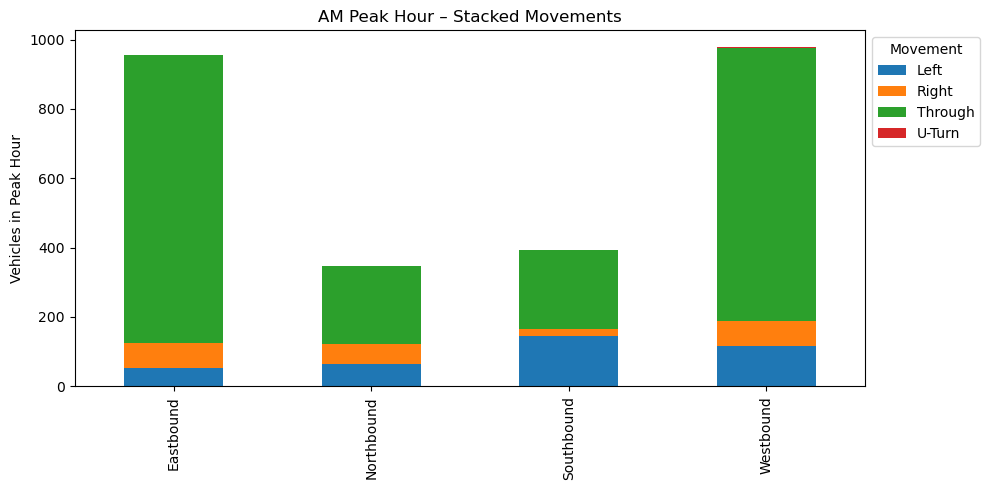

In [100]:
plot_peak_stacked_bars(reports["SR 544 & Charlotte"])

<Axes: title={'center': '15-minute Volumes (combined)'}, xlabel='Time', ylabel='Vehicles per 15 min'>

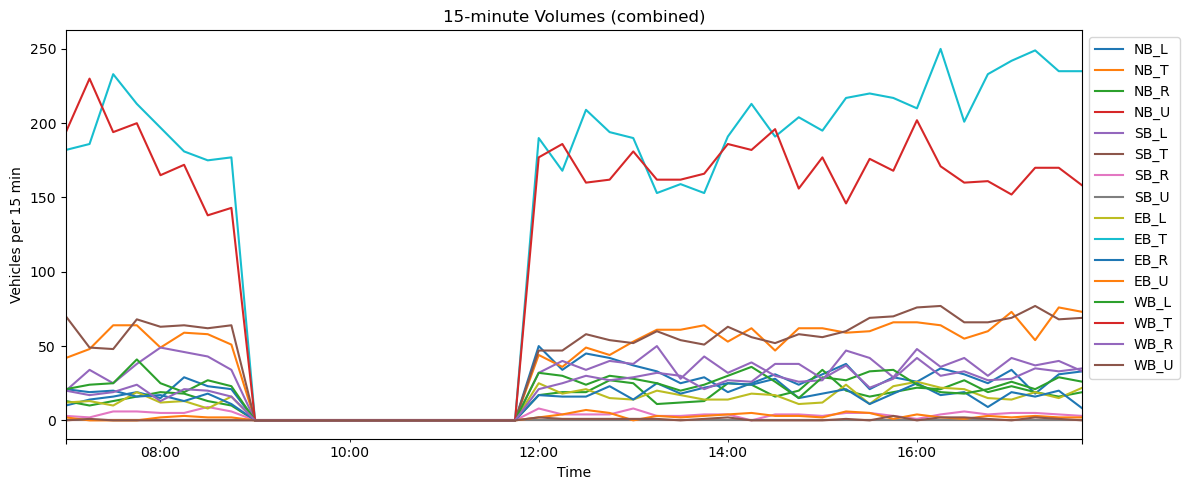

In [101]:
plot_movement_time_series(charlotte)

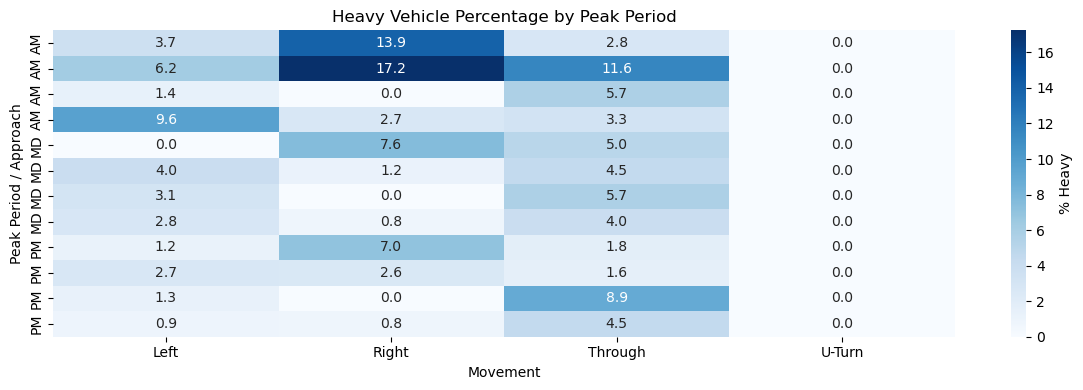

In [102]:
plot_heavy_percentage_heatmap(reports["SR 544 & Charlotte"])

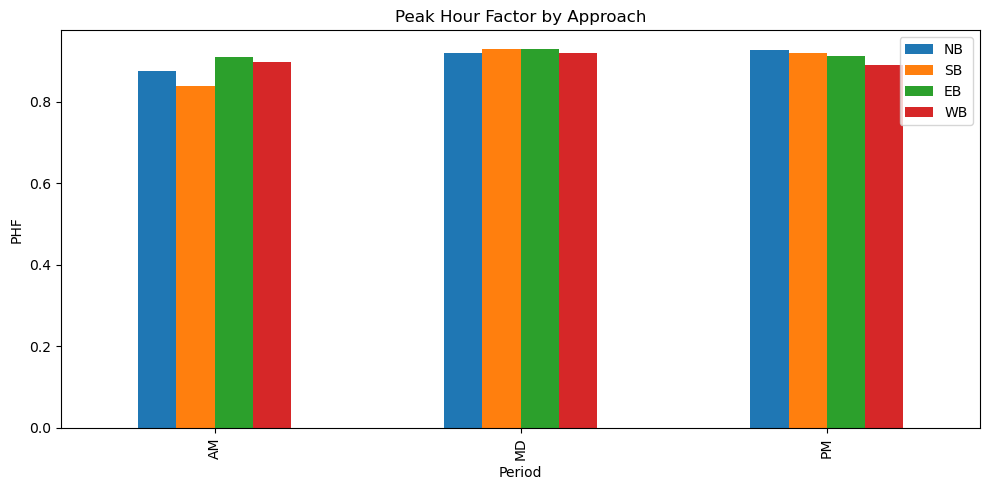

In [104]:
plot_phf_bars(charlotte)

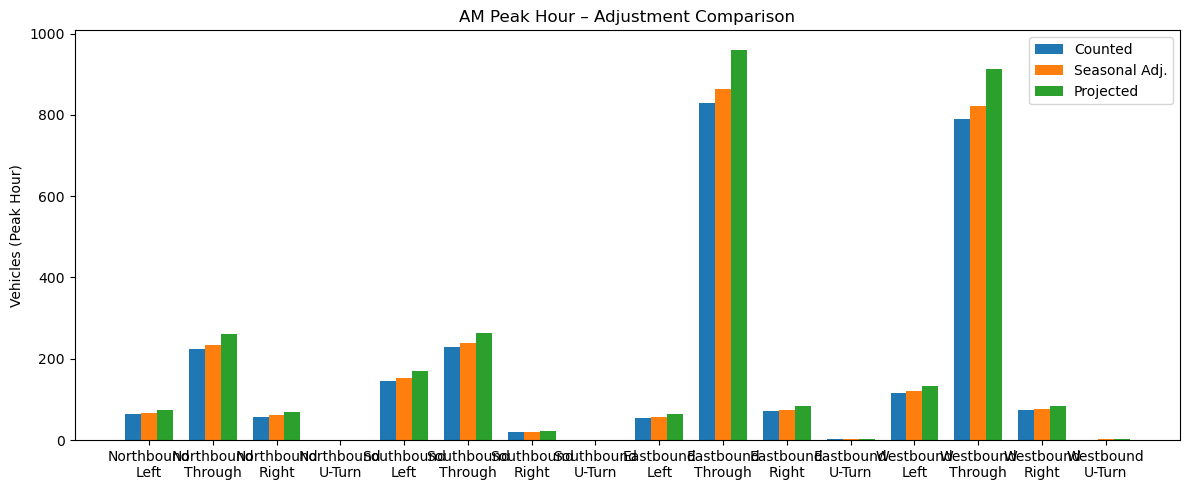

In [ ]:
plot_adjusted_volume_comparison(reports["SR 544 & Charlotte"])